In [1]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras.layers import Flatten, Conv2D, MaxPooling2D
from keras.losses import sparse_categorical_crossentropy, mse
from keras.metrics import sparse_categorical_accuracy
from keras.optimizers import Adam
from keras import backend as K

from keras_utils import SampleMultinomial

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
num_classes = 10
batch_size = 128
epochs = 12

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# input image dimensions
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

('x_train shape:', (60000, 28, 28, 1))
(60000, 'train samples')
(10000, 'test samples')


In [3]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [5]:
samples = SampleMultinomial()(model.output)
samples = samples[:, np.newaxis]

def my_sparse_categorical_accuracy(y_true, y_pred):
    return K.cast(K.equal(y_true, K.cast(y_pred, K.floatx())), K.floatx())

def reinforce_loss(y_true, y_pred):
    rewards = my_sparse_categorical_accuracy(y_true, samples)
    advantages = K.stop_gradient(rewards - K.mean(rewards))
    return advantages * sparse_categorical_crossentropy(samples, y_pred)[:, np.newaxis]

model.compile(loss=reinforce_loss, optimizer=Adam(lr=0.001), metrics=['sparse_categorical_accuracy'])

In [6]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 17s - loss: -0.0687 - sparse_categorical_accuracy: 0.7021 - val_loss: -0.0346 - val_sparse_categorical_accuracy: 0.8490
Epoch 2/12
60000/60000 [==============================] - 16s - loss: -0.0408 - sparse_categorical_accuracy: 0.8304 - val_loss: -0.0206 - val_sparse_categorical_accuracy: 0.8650
Epoch 3/12
60000/60000 [==============================] - 16s - loss: -0.0276 - sparse_categorical_accuracy: 0.8445 - val_loss: -0.0143 - val_sparse_categorical_accuracy: 0.8715
Epoch 4/12
60000/60000 [==============================] - 16s - loss: -0.0221 - sparse_categorical_accuracy: 0.8510 - val_loss: -0.0138 - val_sparse_categorical_accuracy: 0.8737
Epoch 5/12
60000/60000 [==============================] - 16s - loss: -0.0211 - sparse_categorical_accuracy: 0.8561 - val_loss: -0.0104 - val_sparse_categorical_accuracy: 0.8715
Epoch 6/12
60000/60000 [==============================] - 16

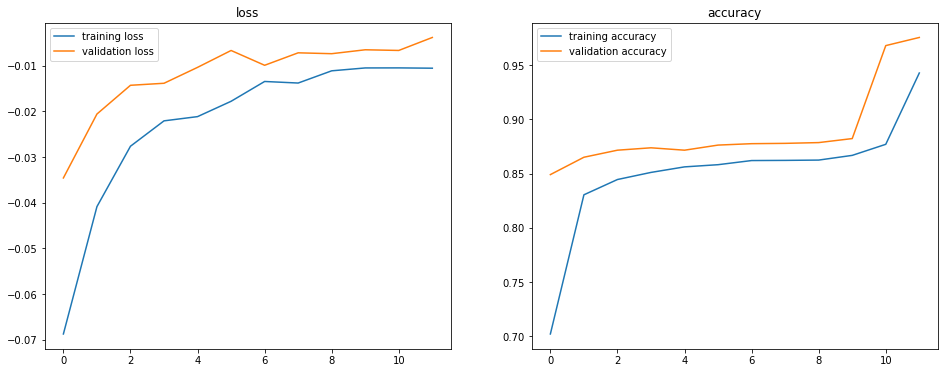

In [9]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'validation loss'])
plt.title('loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.legend(['training accuracy', 'validation accuracy'])
plt.title('accuracy')

In [8]:
score = model.evaluate(x_test, y_test, verbose=0)
#print('Test loss:', score[0])
print('Test accuracy:', score[1])

('Test accuracy:', 0.97540000000000004)
